# Time Series

*Tuesday, September 24*

This Notebook presents the tools we need to analyse time series in Python.

We first review some essential results about covariance stationarity and strict stationarity, MA, AR and ARMA processes. We then use the `statsmodels` library to decompose seasonal time series into trends and cyclical components, we show how to do time series forecasting and how to use common filters. Finally, we implement tests of unit roots in `statsmodels`.

Some familiarity with time-series is required.

### Content

- [1. Short introduction to properties of time-series](#1.-Short-introduction-to-properties-of-time-series)
    - [1.1. Covariance stationarity and stationarity](#1.1.-Covariance-stationarity-and-stationarity)
    - [1.2. Examples](#1.2.-Examples)
    - [1.3. Wold's decomposition theorem](#1.3.-Wold's-decomposition-theorem)
    - [1.4. AR(p) processes](#1.4.-AR(p)-processes)
    - [1.5. MA(p) processes](#1.5.-MA(q)-processes)
    - [1.6. ARMA(p, q) processes](#1.6.-ARMA(p,-q)-processes)
- [2. Time series in statsmodels](#2.-Time-series-in-statsmodels)
    - [2.1. Seasonal decomposition](#2.1.-Seasonal-decomposition)
    - [2.2. Time series forecasting](#2.2.-Time-series-forecasting)
    - [2.3. Time series filters](#2.3.-Time-series-filters)
    - [2.4. Tests of stationarity and unit roots](#2.4.-Tests-of-stationarity-and-unit-roots)


### 1. Short introduction to time-series

A time series is a collection of data points indexed by time. Formally, it is a sequence of random variables ${X_t}$, where $t \in \mathbb N$ or $t \in \mathbb Z$, and $X_t \in \mathbb R, \forall t$.

#### 1.1. Covariance stationarity and stationarity

A time series is said to be covariance stationary if:
* its mean is constant across time periods/does not depend on $t$: $\mathbb E [X_t] = \mu \quad \forall t$
* its variance is constant across time periods/does not depend on $t$: $ \mathrm{Var}[X_t] = \sigma^2 \quad$
* its autocovariance is finite and constant for two random variables equally spaced in time: $\mathrm{cov}(X_t, X_{t+k}) = \mathrm{cov}(X_{t+n}, X_{t+n+k})$

A time series is strictly stationary if:
* the probability mass function of every random variable of the series is the same for all $t$: $f_{X_t}(x) = f_{X_s}(x) \quad \forall t, s$
* The joint probability mass function of two random variables of the series temains unchanged under time-shifts  $f_{X_t, X_s}(x_t, x_s) = f_{X_{t+k}, X_{s+k}}(x_t, x_s) \quad \forall t, s, l$

#### 1.2. Examples

**A white noise process** is a random signal with equal intensity at all frequencies. It is defined as  a random process with mean zero, constant variance and 0 auto-covariance. For instance:
$$X_t = \epsilon_t$$ with $$\epsilon_t \sim \mathcal{N}(0, \sigma^2)$$ 
is a white noise process. White noise processes are covariance stationary.

**Moving Average (MA)** processes are defined as sums of white noise processes with finite coefficients: *e.g.* $$Y_t = \sum_{k=0}^{K} \beta_k \epsilon_{t-k}$$ They also exhibit covariance stationarity.

See the graphs of these processes below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels as sm
%matplotlib nbagg

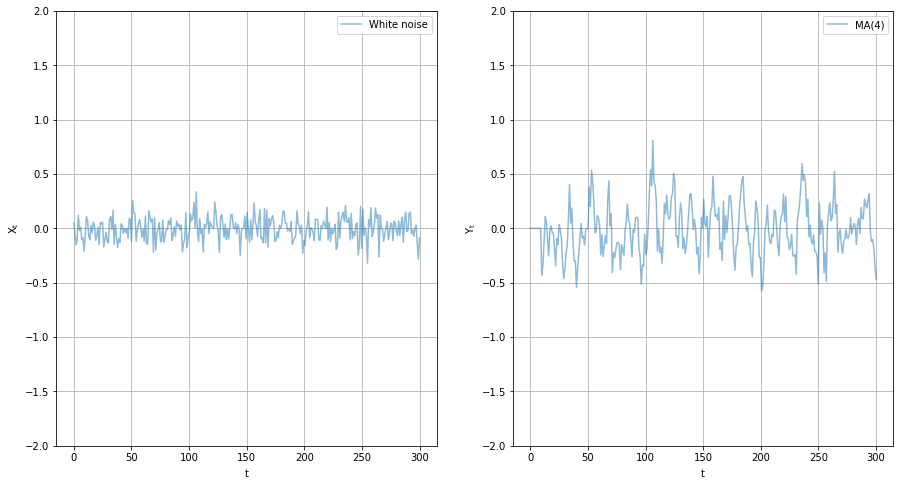

In [2]:
np.random.seed(123456)

t = np.linspace(0, 300, 300)

# Creating a pure white noise process
alpha = 0
epsilon = np.random.normal(loc=0.0, scale = .1, size=len(t))
wn = alpha + epsilon

# Creating MA process with 4 specific coefficients
ma = np.zeros(len(t))
coeffs = [1, 0.7, 1.6, .9]
for k in range(10, len(t)):
    ma[k] = coeffs[0]*epsilon[k] + coeffs[1]*epsilon[k-1] + coeffs[2]*epsilon[k-2] + coeffs[3]*epsilon[k-3]

# Plotting the two time series
plt.figure(1, figsize=(15,8))
plt.subplot(121)
plt.plot(t, wn, alpha=0.5, label='White noise')
plt.xlabel("$\mathrm{t}$")
plt.ylabel("$\mathrm{X_t}$")
plt.ylim(-2, 2)
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(t, ma, alpha=0.5, label='MA(4)')
plt.xlabel("$\mathrm{t}$")
plt.ylabel("$\mathrm{Y_t}$")
plt.ylim(-2, 2)
plt.legend()
plt.grid()

It is easy to verify that they are covariance stationary.

0-mean processes can describe a wide variety of time-series with real applications in economics and finance. The 0-mean assumption is also without loss of generality as this does not affect the variance and covariance of the processes. Moreover, the mean of the random variables is still the same, up to an additive constant.


#### 1.3. Wold's decomposition theorem

There are many different types of covariance-stationary processes (more examples below). But a theorem allows us to characterise them precisely.

[Wold's representation theorem](https://en.wikipedia.org/wiki/Wold%27s_theorem) (Herman Wold, 1908-1992) says that every covariance-stationary time series $X_t$ can be written as the sum of two time series, one *deterministic* and one *stochastic*.

Formally
$$X_{t}=\sum _{k=0}^{\infty }b_{k}\varepsilon _{t-k}+\eta _{t}$$
where:
* $X_t$ is any covariance-stationary process
* $\varepsilon_t$ terms are white noises
* $\beta_k$ coefficients are potentially infinitely many linear filter weights. They must be square summable ( $\sum _{k=0}^{\infty }|b_{k}|^{2} < \infty$ ), constant, and causal (*i.e.* $k \geq 0$)
* $\eta_t$ is a deterministic time series, for instance a sine wave sampled every $\dfrac{\pi}{8}$

We review below the stationary processes you are most likely to encounter in your research.

#### 1.4. AR(p) processes

Auto-regressive processes of order $p$ are defined as $$ X_{t}=c+\sum _{k=1}^{p}\varphi _{k}X_{t-k}+\varepsilon _{t}$$ 

They are common in economics and finance. With many applications to financial and macroeconomic time series. For an AR(p) process to be stationary, the roots of the polynomial $ \Phi (z):=\textstyle 1-\sum _{i=1}^{p}\varphi _{i}z^{i} $ must lie outside the unit circle, *i.e.*, each (complex) root $ z_{i} $ must satisfy $ |z_{i}|>1 $. For an AR(1) process, this simply means: $|\varphi_1 | < 1 $.

An AR(1) process is simply defined as $$ X_t = \varphi X_{t-1} + \varepsilon_t $$ or by repeated substitutions: $$ X_t = \sum_{k=0}^{\infty} \varphi^k \varepsilon_{t-k}$$ 

We get:
$$ \mathbb E[X_t] = 0, \quad \mathrm{cov}(X_t, X_{t-k}) = \sigma^2 \dfrac{\varphi^k}{1-\varphi^2}, \quad \mathrm{and} \quad \mathrm{Var}(X_t) = \dfrac{\sigma^2}{1 - \varphi^2} $$

So it is covariance-stationary.

We can visualise such process easily:

In [3]:
# Time
t = np.linspace(1, 50, 50)

# Parameters
np.random.seed(123456)
epsilon2 = np.random.normal(loc=0.0, scale = 0.5, size=len(t))
phi = 0.85

# Series
X_t = np.zeros(len(t))
X_t[0] = 1
for k in range(1, len(t)):
    X_t[k] = X_t[k-1]*phi + epsilon2[k]

X_neg_t = np.zeros(len(t))
X_neg_t[0] = 1
for k in range(1, len(t)):
    X_neg_t[k] = X_neg_t[k-1]*(-phi) + epsilon2[k]    

# Covariances
acov1 = [phi**k/(1 - phi**2) for k in t]
acov2 = [(-phi)**k/(1 - phi**2) for k in t]

For both series, the autocovariance of the $k^{th}$ term with the first term deacreases asymptotically toward zero as time elapses.

(-4, 4)

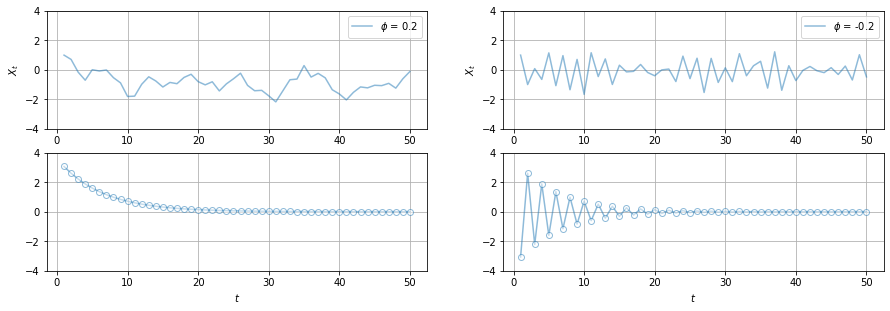

In [4]:
# Plot
plt.figure(2, figsize=(15,10))
plt.subplot(421)
plt.plot(t, X_t, alpha=0.5, label = '$\phi $ = 0.2')
plt.grid()
plt.ylabel("$X_t$")
plt.legend()
plt.ylim(-4, 4)

plt.subplot(423)
plt.plot(t, acov1, marker='o', fillstyle='full', markerfacecolor='white', alpha=0.5)
plt.grid()
plt.xlabel("$t$")
plt.ylim(-4, 4)

plt.subplot(422)
plt.plot(t, X_neg_t, alpha=0.5, label = '$\phi $ = -0.2')
plt.ylabel("$X_t$")
plt.legend()
plt.grid()
plt.ylim(-4, 4)

plt.subplot(424)
plt.plot(t, acov2, marker='o', fillstyle='full', markerfacecolor='white', alpha=0.5)
plt.grid()
plt.xlabel("$t$")
plt.ylim(-4, 4)

#### 1.5. MA(q) processes

A moving average process of order $p$ is defined as $$X_t = \mu + \sum_{k=0}^p \varphi_k \varepsilon_{t-k}$$ and its properties are:

$$ \mathrm{var}(X_t) = \sigma^2 (1 + \sigma^2), \quad \mathrm{cov}(X_t, X_{t+1}) = \sigma^2 \varphi, \quad \mathrm{and}  \quad \mathrm{cov}(X_t, X_{t+k}) = 0 \quad \mathrm{for} \quad k>1  $$


#### 1.6. ARMA(p, q) processes

ARMA(p, q) processes are simply defined as $$ X_t = \sum_{k=0}^p \theta_i X_{t-i} + \sum_{i=0}^q \varphi_k \varepsilon_{t-k} $$

Or with the lag operator $L^k X_t = X_{t-k}$, the expression above can be written:

$$\begin{split}
X_t - \sum_{k=0}^p \theta_i L^k X_t = & \sum_{i=0}^q \varphi_k L^i \varepsilon_t \\
L^0 X_t - \theta_1 L^1 X_t - ... - \theta_p L^p X_t = & L^0 \varepsilon_t + \varphi_1 L^1 \varepsilon_t + ... + \varphi_q L^q \varepsilon_t
\end{split}$$

Defining the polynomials  $ \theta(x) $ and $ \varphi(x) $ to be the corresponding polynomials of the left- and right-hand sides respectively:

$$\begin{split}
\theta(x) := 1 - \theta_1 x - ... - \theta_p x^p
\quad \text{and} \quad
\varphi(x) := 1 + \varphi_1 x + ... + \varphi_q x^q
\end{split}$$

We get the following sufficient condition for the covariance-stationarity of $X_t$: 
**$X_t$ is covariance-stationary if the roots of of the $\theta(x)$ polynomial associated with the AR(p) part of the ARMA(p, q) process lie outside of the unit disk in the complex plane.**


### 2. Time series in statsmodels

`statsmodels` provides us with the tools necessary to analyse and tests ARMA processes in Python. These functions are accessed through the `tsa` submodule of `statsmodels`.

Other notable modules to deal with time-series are QuantEcon's `arma.py` module (imported through the [`QuantEcon.py` package](https://quantecon.org/quantecon-py)), and the probabilistic programming module [PyMC3](https://docs.pymc.io/). We will not cover them in this lecture, but simply list them here as references.

In this section, we provide a partial overview of some of the most useful functions of `tsa` for social science research.


#### 2.1. Seasonal decomposition

Many socio-economic time series such as GDP, average education, consumer price indices, or life expectancy have a persistent growth trend that makes them unsuitable to analytical techniques designed for stationary time series.

`seasonal_decompose` can be used to separate additive or multiplicative time trends from seasonal fluctuations, in a time series.

We apply such decomposition to US real GDP below. We purposedly use a non-seasonally adjusted dataset. On the St.-Louis Fed's website, we can find such time-series, covering the 1947-2019 period, measured in US$ millions. You can find this series [here](https://fred.stlouisfed.org/series/NA000334Q)

In [5]:
gdp = pd.read_csv('https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=748&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=NA000334Q&scale=left&cosd=1947-01-01&coed=2019-04-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Quarterly&fam=avg&fgst=lin&fgsnd=2009-06-01&line_index=1&transformation=lin&vintage_date=2019-09-11&revision_date=2019-09-11&nd=1947-01-01',
                parse_dates=['DATE'], index_col='DATE')
print(gdp.head())
print(gdp.dtypes)

            NA000334Q
DATE                 
1947-01-01    58497.0
1947-04-01    60672.0
1947-07-01    62196.0
1947-10-01    68250.0
1948-01-01    64258.0
NA000334Q    float64
dtype: object


/Users/arnauddyevre/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


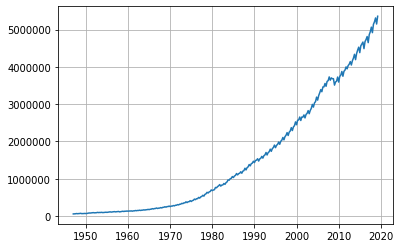

In [6]:
plt.figure(3)
plt.plot(gdp['NA000334Q'])   # Note: we do not need to specify the dates here as they are already defined as indices
plt.grid()

It is rather obvious that we would need a multiplicative decomposition, but we try the additive decomposition as well here for the sake of exposition. `seasonal_decompose` is useful in that it stores the trend --multiplicative or additive--, the seasonal component, and the residual in a custom-made container called `DecomposeResult`. It also allows us to plot the results of the decomposition in a few lines of code.

Note how the residual of the additive decomposition still have some pattern.

Text(0.5, 0.98, 'Additive Decompose')

<Figure size 432x288 with 0 Axes>

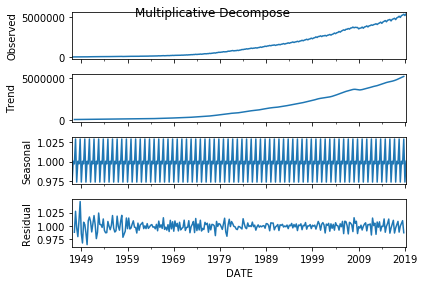

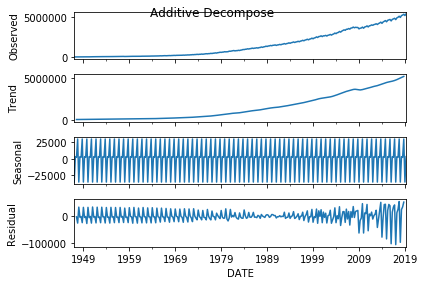

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Multiplicative decomposition 
mul = seasonal_decompose(gdp['NA000334Q'], model='multiplicative')

# Additive decomposition
add = seasonal_decompose(gdp['NA000334Q'], model='additive')

plt.figure(4)
mul.plot().suptitle('Multiplicative Decompose')
add.plot().suptitle('Additive Decompose')

Let's now store all the separate components of the decompositions, so as to be able to re-use them later. We wrap them in a Panda dataframe:

In [8]:
gdp_add = pd.concat([add.seasonal, add.trend, add.resid, add.observed], axis=1)
gdp_mul = pd.concat([mul.seasonal, mul.trend, mul.resid, mul.observed], axis=1)
gdp_add.columns = ['Seasonal', 'Trend', 'Residual', 'Observed']
gdp_mul.columns = ['Seasonal', 'Trend', 'Residual', 'Observed']

gdp_add.head()

,Seasonal,Trend,Residual,Observed
DATE,,,,
1947-01-01,-35120.442421,NaN,NaN,58497.0
1947-04-01,3216.837509,NaN,NaN,60672.0
1947-07-01,2090.884922,63123.875,-3018.759922,62196.0
1947-10-01,29812.719991,64577.375,-26140.094991,68250.0
1948-01-01,-35120.442421,66208.500,33169.942421,64258.0


#### 2.2. Time series forecasting


Statsmodels provides us with many tools to model and predict time series: it handles AR, MA, ARMA, ARIMA, SARIMA, VAR, and VARMA among other.

We briefly review the AR, MA, ARMA and ARIMA processes below.

##### 2.2.1. AR

Here we define a simple AR process, and get `statsmodels` to estimate its coefficients and predict its next value. We plot the process for more clarity.

Let's work with the following AR(2) process:

$$ X_t = \alpha + \varphi_1 X_{t-1} + \varphi_2 X_{t-2} + \varepsilon_t \\
\mathrm{with} \quad \alpha = 2, \quad \varphi_1 = 0.5, \quad \varphi_2 = 0.9\\
\mathrm{and} \quad \varepsilon_t \sim \mathcal{N}(0, 1) $$

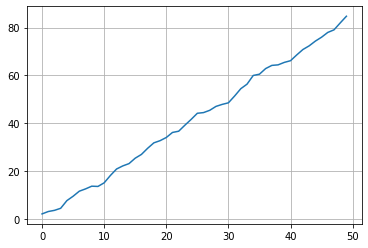

In [10]:
# Time
t = np.linspace(1, 50, 50)

# Parameters
np.random.seed(123456)
epsilon = np.random.normal(loc=0.0, scale = 1, size=len(t))
α, phi_1, phi_2 = 2, 0.5, 0.9

# Series
X_t = np.zeros(len(t))
X_t[0], X_t[1] = 2, 3    # Initialising the series
for k in range(2, len(t)):
    X_t[k] = α + phi_1*X_t[k-1] + phi_1*X_t[k-1] + epsilon[k]
    
# Plotting the series
plt.figure(5)
plt.plot(X_t)
plt.grid()

To facilitate the exposition of the properties of the time series we manipulate, we use a very helpful bit of code written by IBM data scientist [Sean Abu](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/). This code allows us to generate 5 informative time series plots in one line. We get:
* The line plot of the series with respect to time
* The evolution of the autocorrelation function (ACF) over time
* The partial autocorrelation function (PACF) of the series
* Quantile-quantile plots of the distribution of our data compared to that of a normal distribution
* A probability plot (two cdfs plotted against each other), comparing the empirical cdf to that of the normal distribution

See below:

In [9]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from matplotlib import pyplot as plt

def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

<Figure size 432x288 with 0 Axes>

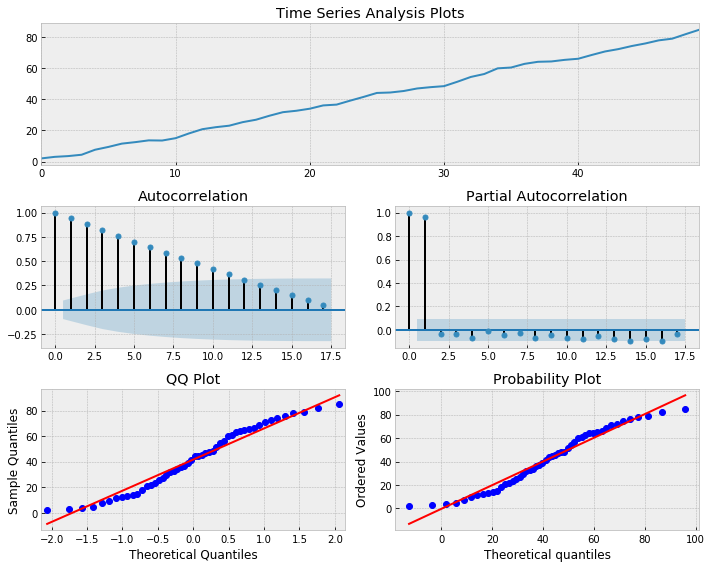

In [11]:
plt.figure(6)
tsplot(X_t)

Now we can estimate the parameters of the model using `statsmodels.tsa.ar_model.AR`.

When estimating the model parameters, `statsmodels` is fitting an unconditional maximum likelihood process.

Below, we use the `ARMA` function from `statsmodels.tsa.arima_model`. It takes as arguments:
* The time series we wish to analyse
* The functional form we impose on it. For instance, if we expect the process to be an ARMA(2, 0)=AR(2), as defined above, we type `ARMA(data_series, order=(2, 0))`

In [12]:
from statsmodels.tsa.arima_model import ARMA

# We define the model and estimate it with the same syntax as OLS
ar20_model = ARMA(X_t, order=(2,0))
model_fit20 = ar20_model.fit()

# Predicting the value coming after the last one
y_hat20 = model_fit20.predict(len(X_t), len(X_t))

# Predicting the 10 values before the last one (in-sample), and the 20 values coming after the last one 
y_hat20_2 = model_fit20.predict(len(X_t)-10, len(X_t)+20)

# Results
print('constant, phi_1 and phi_2:', model_fit20.params)
print('y_41 = ', y_hat20)
print('y_41 to y_71 = ', y_hat20_2)

/Users/arnauddyevre/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


constant, phi_1 and phi_2: [ 2.29427294e+03  1.80406166e+00 -8.04061745e-01]
y_41 =  [86.99597189]
y_41 to y_71 =  [66.25035494 66.69402092 70.48130671 72.64775036 73.57371773 75.9280782
 77.28525263 79.565658   79.90534735 84.26347419 86.99597189 88.80992948
 90.268643   91.44171822 92.38512252 93.14385715 93.7541059  94.24496277
 94.63982117 94.95749084 95.21309597 95.41879737 95.58437306 95.7176852
 95.82505543 95.91156677 95.98130625 96.03756012 96.08297073 96.11966268
 96.14934428]


Note that if we force a different model to be estimated on this data, such as ARMA(3, 0). We get parameter values that are wide off the mark:

In [13]:
ar30_model = ARMA(X_t, order=(3,0))
model_fit30 = ar30_model.fit()

# Predicting the value coming after the last one
y_hat30 = model_fit30.predict(len(X_t), len(X_t))

# Predicting the 10 values before the last one (in-sample), and the 20 values coming after the last one 
y_hat30_2 = model_fit30.predict(len(X_t)-10, len(X_t)+20)

# Results
print('constant, phi_1, phi_2 and phi_3:', model_fit30.params)
print('y_41 = ', y_hat30)
print('y_41 to y_71 = ', y_hat30_2)

constant, phi_1, phi_2 and phi_3: [ 1.64899971e+03  1.63059766e+00 -3.10510326e-01 -3.20087668e-01]
y_41 =  [87.43659088]
y_41 to y_71 =  [ 66.1432579   66.90203276  70.28877271  73.02578706  74.03774934
  76.07300152  77.63726615  79.74427317  80.35708827  84.10623163
  87.43659088  90.03537476  92.53776522  94.94812738  97.26960151
  99.50556514 101.6591533  103.73342407 105.7313094  107.65563703
 109.50912865 111.29440568 113.01399239 114.67031971 116.26572856
 117.80247325 119.28272469 120.70857342 122.08203265 123.40504106
 124.67946561]


/Users/arnauddyevre/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


We can now compare the results of our predictions generated by the two models.

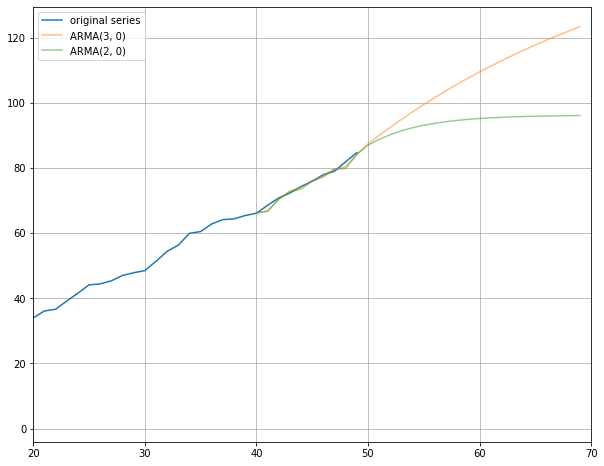

In [14]:
# Defining numpy arrays containing the predicted values, and starting at index 
graph20, graph30 = np.full(71, np.nan), np.full(71, np.nan)
for k in range(30):
    graph20[40+k] = y_hat20_2[k]
    graph30[40+k] = y_hat30_2[k]

# Figure
plt.figure(7, figsize=(10,8))
plt.plot(X_t, label='original series')
plt.plot(graph30, label='ARMA(3, 0)', alpha=0.5)
plt.plot(graph20, label='ARMA(2, 0)', alpha=0.5)
plt.legend()
plt.xlim(20, 70)
plt.grid()

#### 2.2.2. MA and ARMA processes with `statsmodels`

It is straightforward re-use the code above to analyse MA and ARMA processes:
* Fitting an MA model to a time series requires a line like: `model = ARMA(data, order=(0, q))`, with $q \neq 0$
* Fitting an ARMA model requires `model = ARMA(data, order=(p, q))` instead, with $p \neq 0$ and $q \neq 0$

#### 2.2.3. ARIMA(p, d, q) processes

Autoregressive integrated moving average (ARIMA) models are applied to non-stationary processes that can be turned to stationary ones after first differencing the process $d$ times.

Examples:
* ARIMA(0, 1, 0) is a process such as $X_{t}=X_{t-1}+\varepsilon _{t}$. This is simply a random walk
* ARIMA(0, 1, 0) with a constant, or a random walk with drift. *E.g.* by $ X_{t}=c+X_{t-1}+\varepsilon _{t}$
* ARIMA(0, 0, 0) is a white noise process 

They are estimated just like the previous models (`model = ARIMA(data, order=(p, q, q))`).

#### 2.3. Time series filters

The goal of a time series filter is to separate the trend from the cyclical component of a series. They are particularly useful for extracting business cycles from macroeconomic aggregate variables such as GDP, prices and employment.

In this section, we apply the Hodrick-Prescott and Baxter-King filters to income, inflation and unemployment time series.

This section is based on the exposition of filters from the [`statsmodel` documentation](https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_filters.html).

#### 2.3.1. Hodrick-Prescott filter

The HP filter takes as an input a time series $ y_{t}\ =\tau _{t}\ +c_{t}\ +\epsilon _{t}$, where $\tau _{t}$ is the trend component, $c_{t}$ is the cyclical one, and $\epsilon_t$ is an error. Given an adequately chosen positive penalty $\lambda$, there is an optimal trend component $\tau_t$ that solves:
$$ \min _{\tau_t }\left(\sum _{t=1}^{T}{(y_{t}-\tau _{t})^{2}}+\lambda \sum _{t=2}^{T-1}{[(\tau _{t+1}-\tau _{t})-(\tau _{t}-\tau _{t-1})]^{2}}\right) $$ 

The first term is the sum of the squared deviations of the actual data from the trend: it penalises the cyclcical component. The second term is the sum of the squared differences between two consecutive growth terms, it penalises rapid changes in the growth of the trend component. Higher $\lambda$'s increase the smoothing.

Hodrick and Prescott suggest to use a value of 1600 for $\lambda$, when using quarterly data. 

We show a simple application of the HP filter on GDP data. For that, we use one of the default `statsmodels` datasets containing quarterly macroeconomic variables for the US economy. You can have a peak at the available datasets in the `statsmodels` library by typing `sm.datasets.` + `TAB`.

In [15]:
# Loaing the dataset
data = sm.datasets.macrodata.load_pandas().data

# Getting a sense of what the dataset looks like
print(sm.datasets.macrodata.NOTE)
print(data.head())

::
    Number of Observations - 203

    Number of Variables - 14

    Variable name definitions::

        year      - 1959q1 - 2009q3
        quarter   - 1-4
        realgdp   - Real gross domestic product (Bil. of chained 2005 US$,
                    seasonally adjusted annual rate)
        realcons  - Real personal consumption expenditures (Bil. of chained
                    2005 US$, seasonally adjusted annual rate)
        realinv   - Real gross private domestic investment (Bil. of chained
                    2005 US$, seasonally adjusted annual rate)
        realgovt  - Real federal consumption expenditures & gross investment
                    (Bil. of chained 2005 US$, seasonally adjusted annual rate)
        realdpi   - Real private disposable income (Bil. of chained 2005
                    US$, seasonally adjusted annual rate)
        cpi       - End of the quarter consumer price index for all urban
                    consumers: all items (1982-84 = 100, seasonally adju

We have data on deflated GDP, consumption, investment, inflation and many other macroeconomic variables, from 1959 to 2009, by quarter.

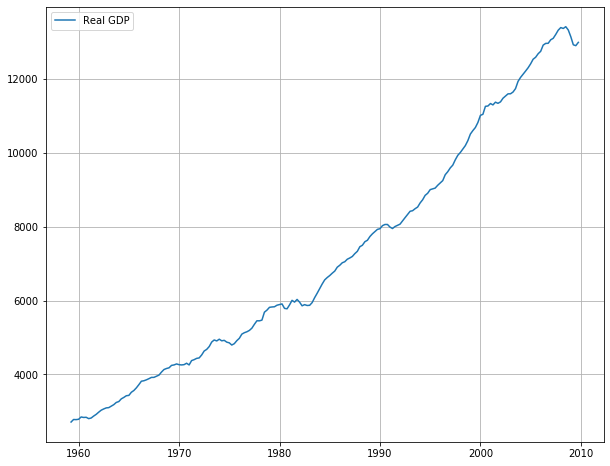

In [16]:
# Defining the date as the index
data.index = pd.Index(sm.tsa.datetools.dates_from_range('1959Q1', '2009Q3'))

# Figure
plt.figure(8, figsize=(10,8))
plt.plot(data.realgdp, label='Real GDP')
plt.legend()
plt.grid()

Now that our data is loaded and indexed, we can apply the HP filter. It takes as an argument a one-dimensional array of the time-series to filter, and the smoothing parameter $\lambda$ (default = 1,600). It outputs two time series:
* The cycle $c_t$
* The optimal trend $\tau_t$

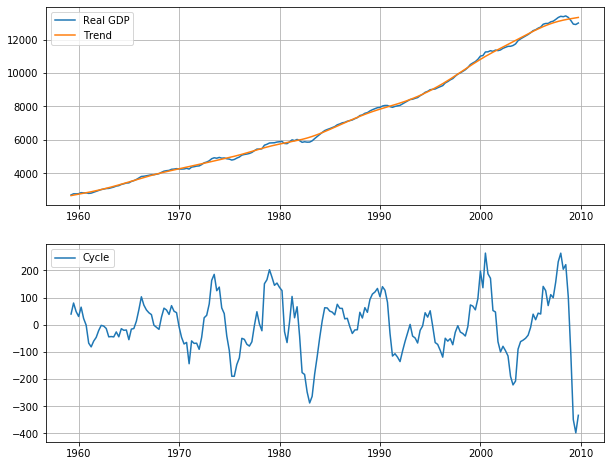

In [17]:
# Detrending
gdp_cycle, gdp_trend = sm.tsa.filters.hpfilter(data.realgdp, lamb=1600)

# Creating a new data frame with the original data and the two new time series
gdp_decomp = data[['realgdp']].copy()
gdp_decomp["cycle"] = gdp_cycle
gdp_decomp["trend"] = gdp_trend

# Plotting the results
plt.figure(9, figsize=(10,8))
plt.subplot(211)
plt.plot(gdp_decomp.realgdp, label='Real GDP')
plt.plot(gdp_decomp.trend, label='Trend')
plt.legend()
plt.grid()

plt.subplot(212)
plt.plot(gdp_decomp.cycle, label='Cycle')
#plt.plot(gdp_decomp.trend, label='Real GDP')
plt.legend()
plt.grid()

#### 2.3.2. Baxter-King bandpass filter

Another commonly used smoothing method is the Baxter-King bandpass filter. Its approach to time series filtering relies on the selection of some frequencies of an oscillating time series $y_t = \tau_t + c_t $. 

Intuitively, if we believe fluctuations with frequencies lower than $\omega_l$ and higher than $\omega_h$ are not informative about the trend component of the time series, we can design a moving-average that ignores these high and low frequencies. This is exactly what the Baxter-King filter does. By removing these undesired oscillations, it identifies a stationary time series corresponding to the business cycle $c_t$.

Note that contrary to the Hodrick-Prescott filter, our primary object of interest is the cycle $c_t$, rather than the trend $\tau_t$ here. The trend is basically eliminated by the BK filter as a low frequency oscillation.

Chosing bounds for the meaningful frequencies is a bit of an arbitrary choice. The consensus in the macroeconomic literature is that cycles with frequencies higher than 32 quarters, or lower than 6, should be ignored by the filter.

Formally, the BK filter outputs a time series $\hat{c}_{t}$ such that

$$\begin{split} \hat{c}_{t} &= \sum_{k=-K}^{k=K}a_k y_{t-k} \\
    & = a_0 y_t + \sum^{K}_{k=1} a_k (y_{t-k} + y_{t+k})
\end{split}$$

where $a_{-k}=a_k$ and $\sum^{K}_{k=-K} a_k = 0$. Each $\hat{c}_{t}$ is a moving average of $K$ lags, $K$ forwards and the actual value $y_t$ at time $t$. **Baxter and King (1999)** derive the following weights:

$$ a_{k}= \dfrac{\left(\omega_{h}-\omega_{l}\right)}{\pi} \quad \textrm{ if } k=0$$ and

$$  a_{k}= \dfrac{\sin \left(j \omega_{h}\right)-\sin \left(j \omega_{l}\right)}{k \pi} \textrm{ if } k \neq 0 $$

with $\omega_h = \dfrac{2 \pi}{p_l}$ and $\omega_h = \dfrac{2 \pi}{p_h}$ being the cutoff high and low frequencies respectively. For instance, if we want to filter out signals with wave periods longer than 32 quarters and lower than 6, then we set $p_l = 6 $ and $ p_h = 32$. These are the default parameters used by the `tsa.filters.bkfilter()` command. 

We show an applictation below, using the time series on unemployment and inflation from the dataset previously imported.

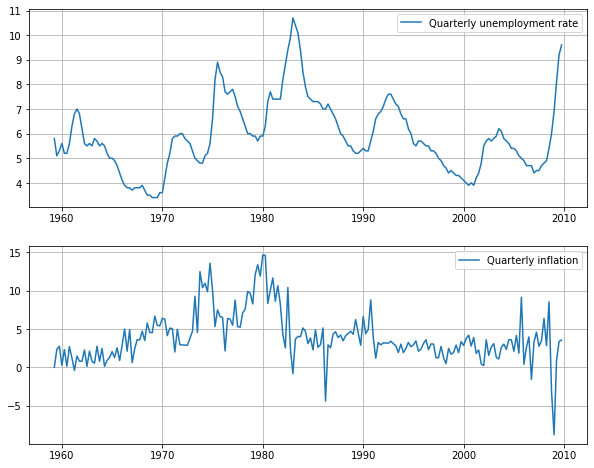

In [18]:
# Fetching the data
unemp = data.unemp
inf = data.infl

# Plotting the series
plt.figure(10, figsize=(10,8))
plt.subplot(211)
plt.plot(unemp, label='Quarterly unemployment rate')
plt.legend()
plt.grid()

plt.subplot(212)
plt.plot(inf, label='Quarterly inflation')
plt.legend()
plt.grid()

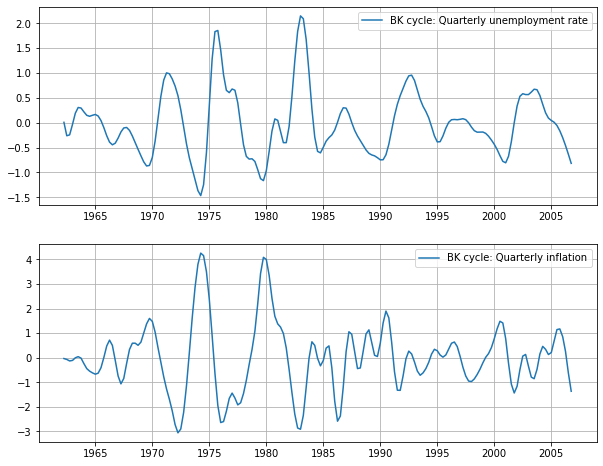

In [19]:
# Applying the BK filter to both series
unemp_bk = sm.tsa.filters.bkfilter(unemp)
inf_bk = sm.tsa.filters.bkfilter(inf)

# Plotting the stationary/cyclic series
plt.figure(11, figsize=(10,8))
plt.subplot(211)
plt.plot(unemp_bk, label='BK cycle: Quarterly unemployment rate')
plt.legend()
plt.grid()

plt.subplot(212)
plt.plot(inf_bk, label='BK cycle: Quarterly inflation')
plt.legend()
plt.grid()

`statsmodels` can also perform Christiano-Fitzgerald filterning for random walks. See [the `statsmodels` documentation](https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_filters.html)  for an application.



#### 2.4. Tests of stationarity and unit roots

##### 2.4.1. Reminders

**Reminder: Unit roots** 

A stochastic process is said to have a unit root, or alternatively to be integrated of order 1, if $1$ is a root of its characteristic polynomial. 

For instance, let's suppose $X_t$ is an auto-regressive process of order p: $X_{t}=a_{1}X_{t-1}+a_{2}X_{t-2}+\cdots +a_{p}X_{t-p}+\varepsilon _{t}$. Its characteristic equation is $x^{p}-x^{p-1}a_{1}-x^{p-2}a_{2}-\cdots -a_{p} = 0$. If $x_0 = 1$ is a root of this polynomial, then $X_t$ has a unit root. 

Such processes can be made covariance-stationary if they are differenced once. In other terms, $X_t - X_{t-1}$ is covariance stationary if $X_t$ has a unit root. We say that such processes are $I(1)$

**Reminder: Integration of order d**

If the characteristic equation of a stochastic process admits $1$ as a root, with multiplicity $d$, then it is integrated of order $d$. By differencing the process $d$ times, we obtain a covariance-stationary process. We say that such processes are $I(d)$

**Reminder: Co-integration** 

Two time series $X_t$ and $Y_t$  are said to be co-integrated of order c if:
* they are both integrated of order $d >c$ *i.e.* $(1 - L)^d X_t$ and $(1 - L)^d Y_t$ are covariance-stationary
* there exist coefficients $a$ and $b$ such that $aX_t + bY_t$ is an integrated series of order $c < d$

##### 2.4.2. Dickey-Fuller test of unit roots

The **Dickey-Fuller** t-test is designed to test for unit roots. Given a time series $X_t = \alpha + \rho X_{t-1} + \varepsilon_{t}$, the DF test is conducted as follows:
* Re-write the process as $\Delta X_t = \alpha + (\rho - 1) X_{t-1} + \varepsilon_t = \delta X_{t-1} + \varepsilon_t $
* Estimate $\delta$ by OLS
* compare the t-value $t = \dfrac{\hat{\delta}}{\mathrm{SE}(\hat{\delta})}$ to the critical value given by the DF statistical table
* The null hypothesis of the DF test is: $H_0$: $X_t$ **has a unit root/is non-stationary**. If $t$ is greater than the critical value under $H_0$ at the desired confidence level, then we conclude that $X_t$ is stationary.

In a similar way, the Dickey-Fuller F-test is used to test for unit roots when the process also has a linear time trend. The transformed series is then $\Delta X_t = \alpha + (\rho - 1) X_{t-1} + \theta t + \varepsilon_t $. The statistical table is different than the DF t-test one though.

We show below how to conduct the Dickey-Fuller test on two synthetic time series with the `adfuller()` function from `statsmodels`. We create a random walk $X_t = X_{t-1} + \varepsilon_t$ (clearly not I(0) or stationary), and a stationary AR(1) process: $W_t = 0.5 W_{t-1} + \epsilon_t $.

In [20]:
# Let's first create a simple time series with a unit root

# Time
t = np.linspace(1, 50, 50)

# Parameters
np.random.seed(123456)
epsilon = np.random.normal(loc=0.0, scale = 0.5, size=len(t))
phi = 1                      # This causes the process to be non stationary

# Series
X_t = np.zeros(len(t))
X_t[0] = 1                   # Initial value
for k in range(1, len(t)):
    X_t[k] = X_t[k-1]*phi + epsilon[k]
    
# Now we create a stationary AR(1) process
np.random.seed(234567)
epsilon_2 = np.random.normal(loc=0.0, scale = 0.5, size=len(t))
phi_2 = 0.5

W_t = np.zeros(len(t))
W_t[0] = 1                   # Initial value
for k in range(1, len(t)):
    W_t[k] = W_t[k-1]*phi_2 + epsilon_2[k]

A simple visualisation of the series can give us a hint as to whether they seem stationary.

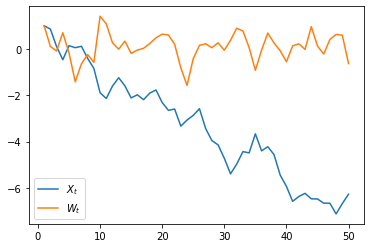

In [21]:
plt.plot(t, X_t, label='$X_t$')
plt.plot(t, W_t, label='$W_t$')
plt.legend()

The Dickey-Fuller and augmented Dickey-Fuller tests are implemented with `adfuller()` in `statsmodels`. They take as arguments: 
* the time series to be tested, entered as a 1-D array of numbers
* whether to include constant and trend parameters in the regression
* a few other options determining how detailed the output of the test should be

They generate:
* the DF test statistic
* the approximate p-value of the test (MacKinnon 1994, 2010)
* the number of lags used
* the number of observations used for the ADF regression and calculation of the critical values
* the critical values

We test below for the presence of a unit root in the random walk $X_t$:

In [22]:
from statsmodels.tsa.stattools import adfuller
ad_result_Xt = adfuller(X_t)
print('ADF Statistic: %f' % ad_result_Xt[0])
print('p-value: %f' % ad_result_Xt[1])
print('Critical Values:')
for key, value in ad_result_Xt[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.407510
p-value: 0.578670
Critical Values:
	1%: -3.571
	5%: -2.923
	10%: -2.599


We cannot reject the null that $X_t$ has a unit root. It is a non-stationary process.

As expected, we can reject the hypothesis that $W_t$ is non-stationary:

In [23]:
ad_result_Wt = adfuller(W_t)
print('ADF Statistic: %f' % ad_result_Wt[0])
print('p-value: %f' % ad_result_Wt[1])
print('Critical Values:')
for key, value in ad_result_Wt[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.444015
p-value: 0.000003
Critical Values:
	1%: -3.575
	5%: -2.924
	10%: -2.600


### References

**Baxter, M., and R. G. King** (1999). "Measuring business cycles: Approximate band-pass filters for economic time series". *Review of Economics
and Statistics* 81: 575–593.